# FlightOnTime - EDA
# Dataset: Airline Delay and Cancellation (2009–2018)
# Task: Clasificación - Riesgo de atraso

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

SEED = 42
np.random.seed(SEED)

# 1) Load data

In [ ]:
#https://www.kaggle.com/datasets/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018?utm_source=chatgpt.com
df = pd.read_csv("/content/drive/MyDrive/Alura/Hackathon/2016.csv", low_memory=False)

print("Shape:", df.shape)
display(df.head())

Shape: (5617658, 28)


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2016-01-01,DL,1248,DTW,LAX,1935,1935.0,0.0,23.0,1958.0,2107.0,13.0,2144,2120.0,-24.0,0.0,NaN,0.0,309.0,285.0,249.0,1979.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,DL,1251,ATL,GRR,2125,2130.0,5.0,13.0,2143.0,2315.0,4.0,2321,2319.0,-2.0,0.0,NaN,0.0,116.0,109.0,92.0,640.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,DL,1254,LAX,ATL,2255,2256.0,1.0,19.0,2315.0,542.0,5.0,600,547.0,-13.0,0.0,NaN,0.0,245.0,231.0,207.0,1947.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,DL,1255,SLC,ATL,1656,1700.0,4.0,12.0,1712.0,2205.0,8.0,2229,2213.0,-16.0,0.0,NaN,0.0,213.0,193.0,173.0,1590.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,DL,1256,BZN,MSP,900,1012.0,72.0,63.0,1115.0,1416.0,4.0,1216,1420.0,124.0,0.0,NaN,0.0,136.0,188.0,121.0,874.0,72.0,0.0,52.0,0.0,0.0,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5617658 entries, 0 to 5617657
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   OP_CARRIER_FL_NUM    int64  
 3   ORIGIN               object 
 4   DEST                 object 
 5   CRS_DEP_TIME         int64  
 6   DEP_TIME             float64
 7   DEP_DELAY            float64
 8   TAXI_OUT             float64
 9   WHEELS_OFF           float64
 10  WHEELS_ON            float64
 11  TAXI_IN              float64
 12  CRS_ARR_TIME         int64  
 13  ARR_TIME             float64
 14  ARR_DELAY            float64
 15  CANCELLED            float64
 16  CANCELLATION_CODE    object 
 17  DIVERTED             float64
 18  CRS_ELAPSED_TIME     float64
 19  ACTUAL_ELAPSED_TIME  float64
 20  AIR_TIME             float64
 21  DISTANCE             float64
 22  CARRIER_DELAY        float64
 23  WEATHER_DELAY        float64
 24

# 2) Column mapping (dataset real)


In [ ]:
COL_DATE = "FL_DATE"
COL_AIRLINE = "OP_CARRIER"
COL_ORIGIN = "ORIGIN"
COL_DEST = "DEST"
COL_SCHED_DEP = "CRS_DEP_TIME"   # HHMM
COL_DEP_DELAY = "DEP_DELAY"      # minutos

# 3) Basic checks

In [ ]:
display(df.dtypes)
display(df.isna().mean().sort_values(ascending=False).head(15))
print("Duplicates:", df.duplicated().sum())

,0
FL_DATE,object
OP_CARRIER,object
OP_CARRIER_FL_NUM,int64
ORIGIN,object
DEST,object
CRS_DEP_TIME,int64
DEP_TIME,float64
DEP_DELAY,float64
TAXI_OUT,float64
WHEELS_OFF,float64


,0
Unnamed: 27,1.000000
CANCELLATION_CODE,0.988276
NAS_DELAY,0.828356
LATE_AIRCRAFT_DELAY,0.828356
SECURITY_DELAY,0.828356
WEATHER_DELAY,0.828356
CARRIER_DELAY,0.828356
ARR_DELAY,0.014154
ACTUAL_ELAPSED_TIME,0.014154
AIR_TIME,0.014154


Duplicates: 0


# 4) Datetime parsing

In [ ]:
# Fecha
df[COL_DATE] = pd.to_datetime(df[COL_DATE], errors="coerce")

# CRS_DEP_TIME viene en formato HHMM (ej: 530, 2215)
def hhmm_to_datetime(row):
    if pd.isna(row[COL_SCHED_DEP]):
        return np.nan
    x = str(int(row[COL_SCHED_DEP])).zfill(4)
    hh = int(x[:2])
    mm = int(x[2:])
    return pd.Timestamp(
        year=row[COL_DATE].year,
        month=row[COL_DATE].month,
        day=row[COL_DATE].day,
        hour=hh,
        minute=mm
    )

df["scheduled_dep_dt"] = df.apply(hhmm_to_datetime, axis=1)

# 5) Target definition (NO leakage)

In [ ]:
DELAY_THRESHOLD = 15

df["delayed"] = (df[COL_DEP_DELAY] > DELAY_THRESHOLD).astype(int)

print(df["delayed"].value_counts())
print(df["delayed"].value_counts(normalize=True))

delayed
0    4698470
1     919188
Name: count, dtype: int64
delayed
0    0.836375
1    0.163625
Name: proportion, dtype: float64


# 6) Cleaning

In [ ]:
required_cols = [
    COL_DATE, COL_AIRLINE, COL_ORIGIN, COL_DEST,
    "scheduled_dep_dt", COL_DEP_DELAY, "delayed"
]

df = df.dropna(subset=required_cols)

# Eliminar vuelos cancelados o desviados
df = df[(df["CANCELLED"] == 0) & (df["DIVERTED"] == 0)]

# Filtro de delays extremos (sanidad)
df = df[(df[COL_DEP_DELAY] > -60) & (df[COL_DEP_DELAY] < 600)]

print("After cleaning:", df.shape)

After cleaning: (5535685, 30)


# 7) Feature engineering (solo pre-vuelo)

In [ ]:
df["sched_hour"] = df["scheduled_dep_dt"].dt.hour
df["day_of_week"] = df[COL_DATE].dt.dayofweek
df["month"] = df[COL_DATE].dt.month
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

df["route"] = df[COL_ORIGIN] + "-" + df[COL_DEST]

print("Unique airlines:", df[COL_AIRLINE].nunique())
print("Unique origins:", df[COL_ORIGIN].nunique())
print("Unique routes:", df["route"].nunique())

Unique airlines: 12
Unique origins: 311
Unique routes: 4549


# 8) EDA - Distribuciones

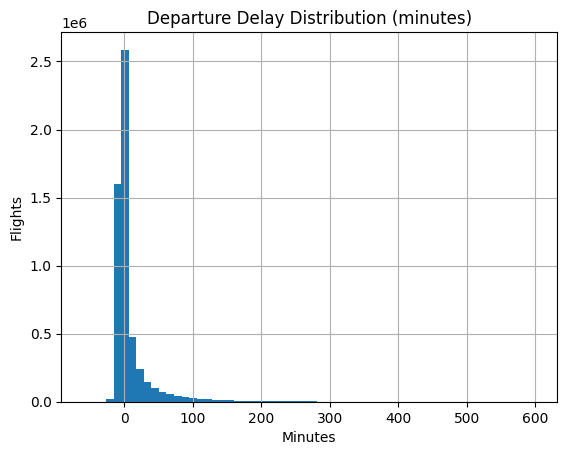

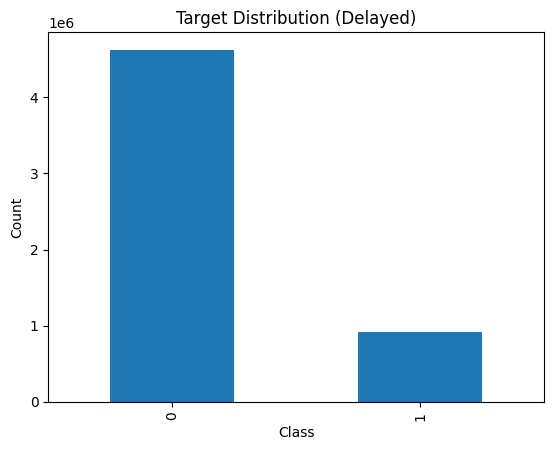

In [ ]:
plt.figure()
df[COL_DEP_DELAY].hist(bins=60)
plt.title("Departure Delay Distribution (minutes)")
plt.xlabel("Minutes")
plt.ylabel("Flights")
plt.show()

plt.figure()
df["delayed"].value_counts().plot(kind="bar")
plt.title("Target Distribution (Delayed)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**Gráfico** 1: Departure Delay Distribution (minutes)

- Una distribución fuertemente asimétrica a la derecha (right-skewed).
- La mayoría de los vuelos están: cerca de 0 minutos,con retrasos pequeños (0–30 min), Existe una cola larga que llega hasta ~600 minutos.

**Gráfico** 2: Target Distribution (Delayed)

Clase 0 (On Time): ~84%

Clase 1 (Delayed): ~16%



# 9) Riesgo de atraso por dimensión

In [ ]:
def risk_table(col, min_count=500):
    tmp = (
        df.groupby(col)
          .agg(
              flights=("delayed", "size"),
              delay_rate=("delayed", "mean")
          )
          .query("flights >= @min_count")
          .sort_values("delay_rate", ascending=False)
    )
    return tmp

display(risk_table(COL_AIRLINE))
display(risk_table(COL_ORIGIN))
display(risk_table(COL_DEST))
display(risk_table("route"))

display(
    df.groupby("sched_hour")
      .agg(flights=("delayed","size"), delay_rate=("delayed","mean"))
      .sort_index()
)

display(
    df.groupby("day_of_week")
      .agg(flights=("delayed","size"), delay_rate=("delayed","mean"))
      .sort_index()
)

,flights,delay_rate
OP_CARRIER,,
B6,277997,0.231024
NK,135319,0.223029
F9,93764,0.210134
VX,68257,0.203466
WN,1280508,0.182593
UA,538035,0.181793
AA,900819,0.163777
EV,477007,0.163297
OO,595077,0.141242


,flights,delay_rate
ORIGIN,,
BQN,1825,0.230685
LAX,210513,0.219796
ORH,695,0.217266
EWR,112489,0.217079
ACV,1361,0.216752
...,...,...
SCC,800,0.050000
RKS,633,0.048973
HLN,1661,0.043949


,flights,delay_rate
DEST,,
PSE,848,0.297170
SWF,716,0.284916
BQN,1831,0.280721
SMX,537,0.268156
ACY,3615,0.242877
...,...,...
BET,958,0.042797
LWS,710,0.040845
BTM,658,0.039514


,flights,delay_rate
route,,
FLL-PIT,858,0.374126
TUS-SFO,798,0.365915
LGA-BHM,502,0.346614
PBI-BOS,1688,0.338270
LAX-ELP,926,0.335853
...,...,...
HLN-SLC,977,0.036847
HNL-LIH,6590,0.036115
GJT-SLC,969,0.033024


,flights,delay_rate
sched_hour,,
0,16075,0.154899
1,5660,0.131272
2,1679,0.217987
3,952,0.215336
4,508,0.145669
5,125536,0.051850
6,381285,0.057870
7,377280,0.077075
8,363028,0.093927


,flights,delay_rate
day_of_week,,
0,816938,0.168161
1,803807,0.152050
2,812462,0.149037
3,821465,0.179641
4,835376,0.183493
5,676256,0.149531
6,769381,0.167115


1️⃣ Riesgo de atraso por aerolínea

❓ Pregunta que responde

¿Qué aerolíneas concentran mayor riesgo estructural de atraso?

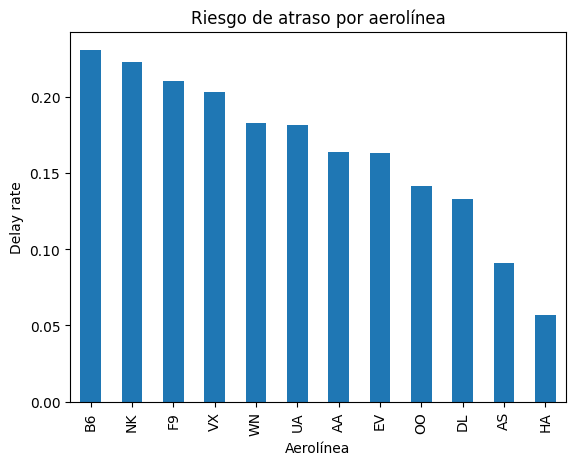

In [ ]:
carrier_risk = (
    df.groupby("OP_CARRIER")
      .agg(
          flights=("delayed", "size"),
          delay_rate=("delayed", "mean")
      )
      .sort_values("delay_rate", ascending=False)
)

plt.figure()
carrier_risk["delay_rate"].plot(kind="bar")
plt.title("Riesgo de atraso por aerolínea")
plt.ylabel("Delay rate")
plt.xlabel("Aerolínea")
plt.show()


2️⃣ Top aeropuertos ORIGIN con mayor riesgo
❓ Pregunta
¿Desde dónde salen más vuelos con riesgo de atraso?

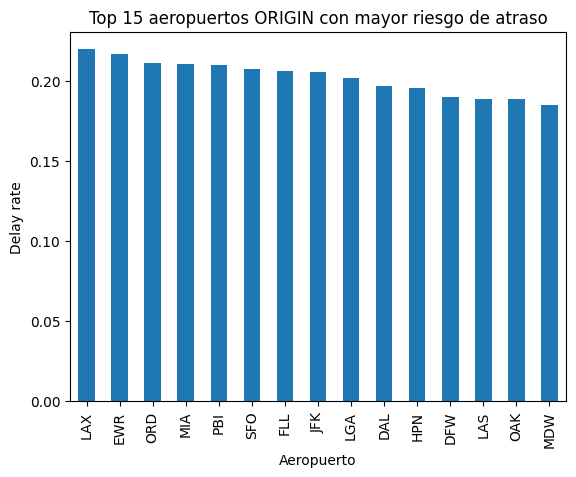

In [ ]:
origin_risk = (
    df.groupby("ORIGIN")
      .agg(
          flights=("delayed", "size"),
          delay_rate=("delayed", "mean")
      )
      .query("flights >= 5000")
      .sort_values("delay_rate", ascending=False)
      .head(15)
)

plt.figure()
origin_risk["delay_rate"].plot(kind="bar")
plt.title("Top 15 aeropuertos ORIGIN con mayor riesgo de atraso")
plt.ylabel("Delay rate")
plt.xlabel("Aeropuerto")
plt.show()


3️⃣ Top aeropuertos DEST con mayor riesgo
❓ Pregunta
¿A qué destinos es más probable llegar tarde (por efecto cascada)?

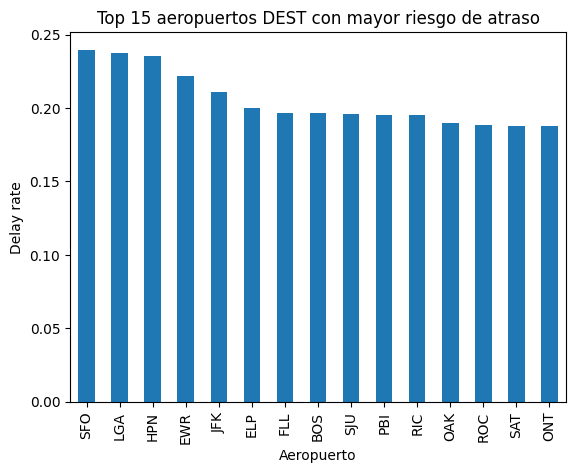

In [ ]:
dest_risk = (
    df.groupby("DEST")
      .agg(
          flights=("delayed", "size"),
          delay_rate=("delayed", "mean")
      )
      .query("flights >= 5000")
      .sort_values("delay_rate", ascending=False)
      .head(15)
)

plt.figure()
dest_risk["delay_rate"].plot(kind="bar")
plt.title("Top 15 aeropuertos DEST con mayor riesgo de atraso")
plt.ylabel("Delay rate")
plt.xlabel("Aeropuerto")
plt.show()


4️⃣ Riesgo de atraso por hora del día
❓ Pregunta
¿A qué horas del día se acumula el atraso?

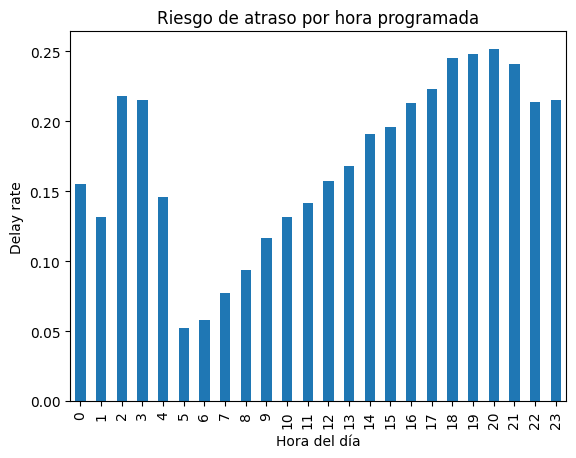

In [ ]:
hour_risk = (
    df.groupby("sched_hour")
      .agg(
          flights=("delayed", "size"),
          delay_rate=("delayed", "mean")
      )
)

plt.figure()
hour_risk["delay_rate"].plot(kind="bar")
plt.title("Riesgo de atraso por hora programada")
plt.ylabel("Delay rate")
plt.xlabel("Hora del día")
plt.show()


5️⃣ Riesgo de atraso por día de la semana
❓ Pregunta
¿Hay patrones semanales operativos?

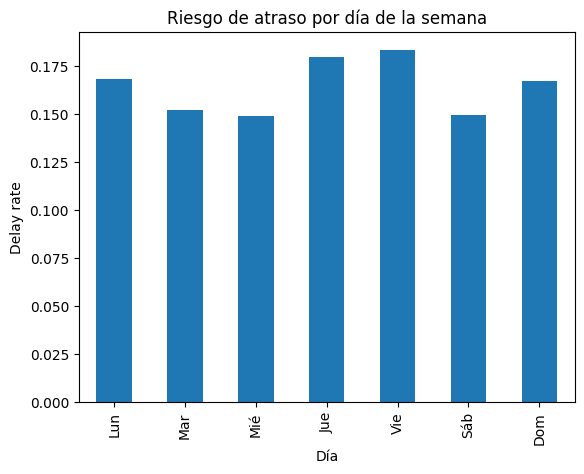

In [ ]:
dow_map = {
    0: "Lun", 1: "Mar", 2: "Mié",
    3: "Jue", 4: "Vie", 5: "Sáb", 6: "Dom"
}

dow_risk = (
    df.groupby("day_of_week")
      .agg(
          flights=("delayed", "size"),
          delay_rate=("delayed", "mean")
      )
)

dow_risk.index = dow_risk.index.map(dow_map)

plt.figure()
dow_risk["delay_rate"].plot(kind="bar")
plt.title("Riesgo de atraso por día de la semana")
plt.ylabel("Delay rate")
plt.xlabel("Día")
plt.show()


6️⃣ Riesgo de atraso por mes (estacionalidad)
❓ Pregunta
¿Existen meses estructuralmente más problemáticos?

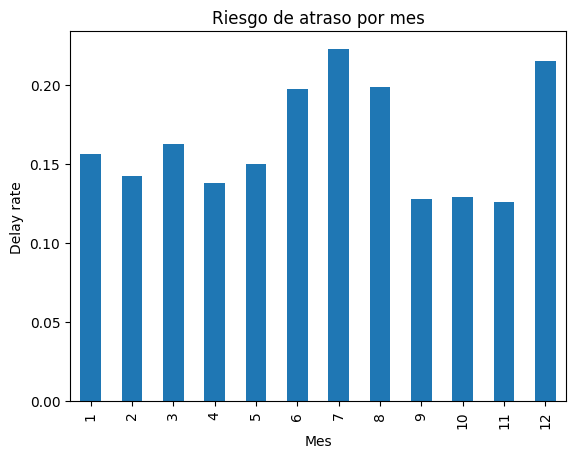

In [ ]:
month_risk = (
    df.groupby("month")
      .agg(
          flights=("delayed", "size"),
          delay_rate=("delayed", "mean")
      )
)

plt.figure()
month_risk["delay_rate"].plot(kind="bar")
plt.title("Riesgo de atraso por mes")
plt.ylabel("Delay rate")
plt.xlabel("Mes")
plt.show()


7️⃣ Top rutas con mayor riesgo
❓ Pregunta
¿Qué combinaciones ORIGIN–DEST son más críticas?

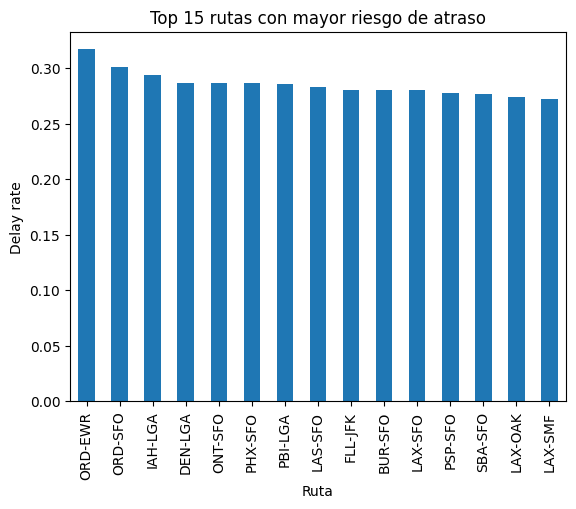

In [ ]:
route_risk = (
    df.groupby("route")
      .agg(
          flights=("delayed", "size"),
          delay_rate=("delayed", "mean")
      )
      .query("flights >= 2000")
      .sort_values("delay_rate", ascending=False)
      .head(15)
)

plt.figure()
route_risk["delay_rate"].plot(kind="bar")
plt.title("Top 15 rutas con mayor riesgo de atraso")
plt.ylabel("Delay rate")
plt.xlabel("Ruta")
plt.show()


# 10) Leakage audit

In [ ]:
LEAKAGE_COLS = [
    "DEP_TIME", "ARR_TIME", "ARR_DELAY",
    "TAXI_OUT", "TAXI_IN", "WHEELS_OFF", "WHEELS_ON"
]

present = [c for c in LEAKAGE_COLS if c in df.columns]
print("Leakage columns present:", present)
print("❌ NO usar estas columnas como features")

Leakage columns present: ['DEP_TIME', 'ARR_TIME', 'ARR_DELAY', 'TAXI_OUT', 'TAXI_IN', 'WHEELS_OFF', 'WHEELS_ON']
❌ NO usar estas columnas como features


# 11) Dataset final para modelado

In [ ]:
feature_cols = [
    COL_AIRLINE, COL_ORIGIN, COL_DEST, "route",
    "sched_hour", "day_of_week", "month", "is_weekend"
]

X = df[feature_cols]
y = df["delayed"]

print("X shape:", X.shape)
print("Delayed rate:", y.mean())

X shape: (5535685, 8)
Delayed rate: 0.16461088374790112


In [ ]:
display(df.dtypes)


,0
FL_DATE,datetime64[ns]
OP_CARRIER,object
OP_CARRIER_FL_NUM,int64
ORIGIN,object
DEST,object
CRS_DEP_TIME,int64
DEP_TIME,float64
DEP_DELAY,float64
TAXI_OUT,float64
WHEELS_OFF,float64


3️⃣ Estadísticas descriptivas

In [ ]:
df.describe()

,FL_DATE,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27,scheduled_dep_dt,delayed,sched_hour,day_of_week,month,is_weekend
count,5535685,5.535685e+06,5.535685e+06,5.535685e+06,5.535685e+06,5.535685e+06,5.535685e+06,5.535685e+06,5.535685e+06,5.535685e+06,5.535685e+06,5.535685e+06,5535685.0,5535685.0,5.535685e+06,5.535685e+06,5.535685e+06,5.535685e+06,961788.000000,961788.000000,961788.000000,961788.000000,961788.000000,0.0,5535685,5.535685e+06,5.535685e+06,5.535685e+06,5.535685e+06,5.535685e+06
mean,2016-07-02 10:32:11.555425792,2.073339e+03,1.330138e+03,1.333506e+03,8.497499e+00,1.618277e+01,1.355030e+03,1.467219e+03,7.448398e+00,1.490145e+03,1.471554e+03,3.141876e+00,0.0,0.0,1.455137e+02,1.401581e+02,1.165269e+02,8.512761e+02,18.670023,2.533027,14.629643,0.084662,24.128947,NaN,2016-07-03 00:01:01.696276480,1.646109e-01,1.303255e+01,2.932283e+00,6.544538e+00,2.611487e-01
min,2016-01-01 00:00:00,1.000000e+00,1.000000e+00,1.000000e+00,-5.900000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.070000e+02,0.0,0.0,1.800000e+01,1.400000e+01,4.000000e+00,2.800000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2016-01-01 00:10:00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2016-04-05 00:00:00,7.100000e+02,9.150000e+02,9.170000e+02,-5.000000e+00,1.100000e+01,9.310000e+02,1.049000e+03,4.000000e+00,1.105000e+03,1.052000e+03,-1.400000e+01,0.0,0.0,8.800000e+01,8.400000e+01,6.200000e+01,3.910000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2016-04-05 06:50:00,0.000000e+00,9.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00
50%,2016-07-03 00:00:00,1.635000e+03,1.325000e+03,1.328000e+03,-2.000000e+00,1.400000e+01,1.340000e+03,1.507000e+03,6.000000e+00,1.520000e+03,1.511000e+03,-6.000000e+00,0.0,0.0,1.260000e+02,1.210000e+02,9.700000e+01,6.790000e+02,1.000000,0.000000,2.000000,0.000000,2.000000,NaN,2016-07-03 08:30:00,0.000000e+00,1.300000e+01,3.000000e+00,7.000000e+00,0.000000e+00
75%,2016-09-29 00:00:00,2.847000e+03,1.735000e+03,1.742000e+03,6.000000e+00,1.900000e+01,1.756000e+03,1.913000e+03,9.000000e+00,1.920000e+03,1.918000e+03,6.000000e+00,0.0,0.0,1.780000e+02,1.730000e+02,1.480000e+02,1.096000e+03,18.000000,0.000000,19.000000,0.000000,30.000000,NaN,2016-09-29 23:50:00,0.000000e+00,1.700000e+01,5.000000e+00,9.000000e+00,1.000000e+00
max,2016-12-31 00:00:00,8.402000e+03,2.359000e+03,2.400000e+03,5.990000e+02,1.860000e+02,2.400000e+03,2.400000e+03,2.500000e+02,2.400000e+03,2.400000e+03,6.540000e+02,0.0,0.0,7.050000e+02,7.780000e+02,7.230000e+02,4.983000e+03,599.000000,599.000000,613.000000,437.000000,598.000000,NaN,2016-12-31 23:59:00,1.000000e+00,2.300000e+01,6.000000e+00,1.200000e+01,1.000000e+00
std,NaN,1.697701e+03,4.893986e+02,5.025082e+02,3.508812e+01,8.811835e+00,5.043117e+02,5.298224e+02,5.681446e+00,5.159936e+02,5.342519e+02,3.760803e+01,0.0,0.0,7.649697e+01,7.565915e+01,7.352399e+01,6.200450e+02,43.831961,17.974322,29.360456,2.373883,44.072761,NaN,NaN,3.708290e-01,4.881052e+00,1.985352e+00,3.397183e+00,4.392609e-01


In [ ]:
df.describe(include="object")

,OP_CARRIER,ORIGIN,DEST,CANCELLATION_CODE,route
count,5535685,5535685,5535685,0,5535685
unique,12,311,310,0,4549
top,WN,ATL,ATL,NaN,SFO-LAX
freq,1280508,381161,380903,NaN,17259


In [ ]:
df = df.drop(columns=["Unnamed: 27"])

In [ ]:
columns_to_drop = [
    'CANCELLED', 'CANCELLATION_CODE', 'TAXI_OUT', 'TAXI_IN',
    'WHEELS_ON', 'WHEELS_OFF', 'DIVERTED'
]

# Eliminar las columnas especificadas en excel Diccionario Variables
df = df.drop(columns=columns_to_drop, errors='ignore')

print(f"Columnas restantes: {df.shape[1]}")
df.info()

Columnas restantes: 27
<class 'pandas.core.frame.DataFrame'>
Index: 5535685 entries, 0 to 5617657
Data columns (total 27 columns):
 #   Column               Dtype         
---  ------               -----         
 0   FL_DATE              datetime64[ns]
 1   OP_CARRIER           object        
 2   OP_CARRIER_FL_NUM    int64         
 3   ORIGIN               object        
 4   DEST                 object        
 5   CRS_DEP_TIME         int64         
 6   DEP_TIME             float64       
 7   DEP_DELAY            float64       
 8   CRS_ARR_TIME         int64         
 9   ARR_TIME             float64       
 10  ARR_DELAY            float64       
 11  CRS_ELAPSED_TIME     float64       
 12  ACTUAL_ELAPSED_TIME  float64       
 13  AIR_TIME             float64       
 14  DISTANCE             float64       
 15  CARRIER_DELAY        float64       
 16  WEATHER_DELAY        float64       
 17  NAS_DELAY            float64       
 18  SECURITY_DELAY       float64       
 19  LAT

In [ ]:
df.to_parquet("flights_2016_clean.parquet")

#12) Split temporal

In [ ]:
# 1️⃣ Ordenar por fecha
df = df.sort_values(COL_DATE)

# 2️⃣ Definir split_date (ejemplo: 80% histórico)
split_date = df[COL_DATE].quantile(0.8)

# 3️⃣ Crear máscaras de entrenamiento y test
train_mask = df[COL_DATE] <= split_date
test_mask  = df[COL_DATE] > split_date

# 4️⃣ Separar los DataFrames
df_train = df.loc[train_mask]
df_test  = df.loc[test_mask]

# 5️⃣ Extraer features y target
X_train = df_train[feature_cols]
y_train = df_train["delayed"]

X_test = df_test[feature_cols]
y_test = df_test["delayed"]

# 6️⃣ Revisar tamaños y tasas de retraso
print("Split date:", split_date)
print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train delayed rate:", y_train.mean(), "Test delayed rate:", y_test.mean())


Split date: 2016-10-18 00:00:00
Train: (4439072, 8) Test: (1096613, 8)
Train delayed rate: 0.16460174559006926 Test delayed rate: 0.16464787486560892


Lo que el modelo aprende en train es representativo de lo que verá en producción.

#13) Encoding sanity check

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#Categorical:
cat_cols = [COL_AIRLINE, COL_ORIGIN, COL_DEST, "route"]
#Numerical:
num_cols = ["sched_hour", "day_of_week", "month", "is_weekend"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

Xt = preprocess.fit_transform(X_train)
print("Encoded matrix shape:", Xt.shape)

Encoded matrix shape: (4439072, 5106)


sanity check
Este paso NO es para entrenar todavía.
Sirve para confirmar que:

* No hay errores de encoding
* Las categorías nuevas se ignoran sin romper (handle_unknown="ignore")
* El pipeline funciona con datos reales
* La dimensionalidad es razonable
* Estás listo para entrenar modelos

#1️⃣ Pipeline: Encoding + Modelo

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


In [ ]:
cat_cols = ["OP_CARRIER", "ORIGIN", "DEST", "route"]
num_cols = ["sched_hour", "day_of_week", "month", "is_weekend"]


In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",   # clave por el 16% de positivos
    n_jobs=-1
)

pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", baseline_model),
    ]
)


##2️⃣ Entrenamiento

In [ ]:
pipeline.fit(X_train, y_train)
print("Baseline trained ✔")


Baseline trained ✔


##3️⃣ Predicciones (probabilidades)

In [ ]:
y_proba_test = pipeline.predict_proba(X_test)[:, 1]


##4️⃣ Métricas correctas

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

roc_auc = roc_auc_score(y_test, y_proba_test)
pr_auc = average_precision_score(y_test, y_proba_test)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC : {pr_auc:.4f}")


ROC-AUC: 0.6428
PR-AUC : 0.2475


##5️⃣ Elegir un umbral operativo (MUY importante)

In [ ]:
from sklearn.metrics import classification_report

y_pred_05 = (y_proba_test >= 0.5).astype(int)
print(classification_report(y_test, y_pred_05, digits=4))


              precision    recall  f1-score   support

           0     0.8908    0.5680    0.6936    916058
           1     0.2278    0.6466    0.3369    180555

    accuracy                         0.5809   1096613
   macro avg     0.5593    0.6073    0.5153   1096613
weighted avg     0.7816    0.5809    0.6349   1096613



##6️⃣ Umbral por percentil (recomendado para negocio)

In [ ]:
import numpy as np

threshold_90 = np.percentile(y_proba_test, 90)
y_pred_top10 = (y_proba_test >= threshold_90).astype(int)

print("Threshold (top 10%):", threshold_90)
print(classification_report(y_test, y_pred_top10, digits=4))


Threshold (top 10%): 0.6899242961858262
              precision    recall  f1-score   support

           0     0.8494    0.9151    0.8810    916058
           1     0.2909    0.1767    0.2199    180555

    accuracy                         0.7935   1096613
   macro avg     0.5701    0.5459    0.5504   1096613
weighted avg     0.7574    0.7935    0.7722   1096613



##7️⃣ Matriz de confusión (visual)

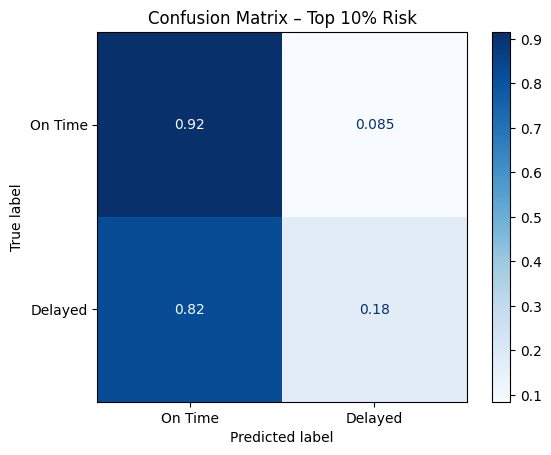

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_top10,
    display_labels=["On Time", "Delayed"],
    cmap="Blues",
    normalize="true"
)
plt.title("Confusion Matrix – Top 10% Risk")
plt.show()


##8️⃣ Interpretabilidad: ¿qué pesa más?

In [ ]:
# Obtener nombres de features tras el encoding
ohe = pipeline.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = list(cat_feature_names) + num_cols

coefs = pipeline.named_steps["model"].coef_[0]

coef_df = (
    pd.DataFrame({
        "feature": feature_names,
        "coef": coefs
    })
    .assign(abs_coef=lambda x: x["coef"].abs())
    .sort_values("abs_coef", ascending=False)
)

coef_df.head(20)


,feature,coef,abs_coef
1151,route_BQN-EWR,1.324601,1.324601
2374,route_HNL-DFW,-1.315044,1.315044
1292,route_CAK-LAS,1.212421,1.212421
2811,route_KOA-PHX,-1.176625,1.176625
2392,route_HNL-SAN,1.141897,1.141897
3689,route_OGG-DFW,-1.108431,1.108431
1863,route_DFW-OGG,1.107868,1.107868
4840,route_SNA-EWR,-1.104415,1.104415
2395,route_HNL-SJC,1.099045,1.099045
2844,route_LAS-CVG,-1.091366,1.091366


#✅ Paso 0 — Preparación y split temporal (sin warning)

In [ ]:
import numpy as np
import pandas as pd

COL_DATE = "FL_DATE"

df = df.sort_values(COL_DATE).reset_index(drop=True)

split_date = df[COL_DATE].quantile(0.8)
train_mask = df[COL_DATE] <= split_date
test_mask  = df[COL_DATE] > split_date

df_train = df.loc[train_mask].copy()
df_test  = df.loc[test_mask].copy()

print("Split date:", split_date)
print("Train:", df_train.shape, "Test:", df_test.shape)
print("Train delayed rate:", df_train["delayed"].mean(), "Test delayed rate:", df_test["delayed"].mean())

# ✅ Check: temporalidad correcta (última fecha train <= primera fecha test)
assert df_train[COL_DATE].max() <= df_test[COL_DATE].min()


Split date: 2016-10-18 00:00:00
Train: (4439072, 34) Test: (1096613, 34)
Train delayed rate: 0.16460174559006926 Test delayed rate: 0.16464787486560892


#✅ Recomendación 1 — Rolling features SIN leakage (garantizado)

##1.1 Función segura (usa solo pasado)

In [ ]:
#df_hist = df.sort_values(COL_DATE).copy()


In [ ]:
def add_group_rolling_rate(
    df, group_col, window=2000, min_obs=200,
    target="delayed", prefix="hist"
):
    shifted = df.groupby(group_col)[target].shift(1)

    roll_sum = (
        shifted
        .groupby(df[group_col])
        .rolling(window=window, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
    )

    roll_cnt = (
        shifted
        .groupby(df[group_col])
        .rolling(window=window, min_periods=1)
        .count()
        .reset_index(level=0, drop=True)
    )

    col_name = f"{prefix}_delay_{group_col}_w{window}"
    df[col_name] = roll_sum / roll_cnt
    df.loc[roll_cnt < min_obs, col_name] = np.nan

    return df, col_name


##1.2 Crear features recomendadas

In [ ]:
# ordenar UNA sola vez
df_hist = df.sort_values(COL_DATE).copy()

# rolling SOLO para grupos grandes
df_hist, f_origin = add_group_rolling_rate(
    df_hist, "ORIGIN", window=3000, min_obs=300
)

df_hist, f_carrier = add_group_rolling_rate(
    df_hist, "OP_CARRIER", window=50000, min_obs=500
)

# histórico global para route (barato)
route_rate = (
    df_hist.groupby("route")["delayed"]
    .mean()
    .rename("hist_route_rate")
)

df_hist = df_hist.join(route_rate, on="route")

hist_cols = [f_origin, f_carrier, "hist_route_rate"]
print("Hist cols:", hist_cols)


Hist cols: ['hist_delay_ORIGIN_w3000', 'hist_delay_OP_CARRIER_w50000', 'hist_route_rate']


##1.3 Relleno SIN leakage (con promedio SOLO del train)

In [ ]:
train_mask = df_hist[COL_DATE] <= split_date
test_mask  = df_hist[COL_DATE] > split_date

global_train_rate = df_hist.loc[train_mask, "delayed"].mean()

for c in hist_cols:
    df_hist[c] = df_hist[c].fillna(global_train_rate)


##1.4 Reconstruir train/test con features históricas

In [ ]:
df_train = df_hist.loc[train_mask].copy()
df_test  = df_hist.loc[test_mask].copy()

base_features = [
    "OP_CARRIER", "ORIGIN", "DEST", "route",
    "sched_hour", "day_of_week", "month", "is_weekend"
]

feature_cols_hist = base_features + hist_cols

X_train = df_train[feature_cols_hist]
y_train = df_train["delayed"]

X_test  = df_test[feature_cols_hist]
y_test  = df_test["delayed"]

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (4439072, 11) X_test: (1096613, 11)


#✅ Recomendación 2 — Manejo de rutas raras (estabilidad)

##2.1 Agrupar rutas con bajo volumen SOLO basado en train (sin leakage)

In [ ]:
min_route_freq = 500  # ajusta según quieras (500-2000 suele ser bien)

route_counts = df_train["route"].value_counts()
common_routes = set(route_counts[route_counts >= min_route_freq].index)

def map_route(r):
    return r if r in common_routes else "OTHER_ROUTE"

X_train = X_train.copy()
X_test = X_test.copy()

X_train["route"] = X_train["route"].map(map_route)
X_test["route"] = X_test["route"].map(map_route)

# ✅ Check: no NaNs generados
assert X_train["route"].isna().sum() == 0
assert X_test["route"].isna().sum() == 0
print("✅ Rare route handling OK. Common routes:", len(common_routes))


✅ Rare route handling OK. Common routes: 2610


#✅ Recomendación 3 — Entrenar baseline mejorado (LR + hist features)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

cat_cols = ["OP_CARRIER", "ORIGIN", "DEST", "route"]
num_cols = ["sched_hour", "day_of_week", "month", "is_weekend"] + hist_cols

preprocess = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    sparse_threshold=0.3
)

lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear"
)

pipe_lr_hist = Pipeline([
    ("preprocess", preprocess),
    ("model", lr),
])

pipe_lr_hist.fit(X_train, y_train)

y_proba = pipe_lr_hist.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba))


ROC-AUC: 0.6748376187476854
PR-AUC : 0.28801171014841953


#✅ Recomendación 4 — Modelo avanzado: LightGBM (mejor desempeño)

##4.1 Instalar (si aplica en Colab)

In [ ]:
# En Colab normalmente:
!pip -q install lightgbm


##4.2 Entrenar LightGBM con el mismo preprocess (OneHot)

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

pipe_lgbm = Pipeline([
    ("preprocess", preprocess),
    ("model", lgbm),
])

pipe_lgbm.fit(X_train, y_train)

y_proba_lgbm = pipe_lgbm.predict_proba(X_test)[:, 1]

print("LGBM ROC-AUC:", roc_auc_score(y_test, y_proba_lgbm))
print("LGBM PR-AUC :", average_precision_score(y_test, y_proba_lgbm))

thr_lgbm = np.percentile(y_proba_lgbm, 90)
y_pred_lgbm = (y_proba_lgbm >= thr_lgbm).astype(int)
print("Top10% threshold (LGBM):", thr_lgbm)
print(classification_report(y_test, y_pred_lgbm, digits=4))

# ✅ Check: normalmente LGBM >= LR en PR-AUC
assert average_precision_score(y_test, y_proba_lgbm) >= average_precision_score(y_test, y_proba) - 0.01
print("✅ LGBM sanity check passed.")


[LightGBM] [Info] Number of positive: 730679, number of negative: 3708393
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 13.818251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7283
[LightGBM] [Info] Number of data points in the train set: 4439072, number of used features: 3244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.164602 -> initscore=-1.624380
[LightGBM] [Info] Start training from score -1.624380


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM ROC-AUC: 0.6889554204348314
LGBM PR-AUC : 0.2985654021538461
Top10% threshold (LGBM): 0.27609278484188626
              precision    recall  f1-score   support

           0     0.8576    0.9240    0.8896    916058
           1     0.3651    0.2218    0.2759    180555

    accuracy                         0.8084   1096613
   macro avg     0.6114    0.5729    0.5828   1096613
weighted avg     0.7765    0.8084    0.7885   1096613

✅ LGBM sanity check passed.


#✅ Recomendación 5 — Gráficas finales (y checks de que están bien)

##5.1 Barras: riesgo por hora (EDA)

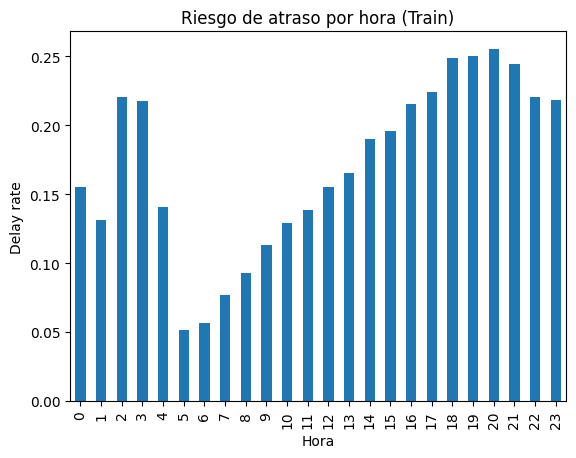

✅ Hour plot check passed.


In [ ]:
import matplotlib.pyplot as plt

hour_risk = df_train.groupby("sched_hour")["delayed"].mean().sort_index()

plt.figure()
hour_risk.plot(kind="bar")
plt.title("Riesgo de atraso por hora (Train)")
plt.xlabel("Hora")
plt.ylabel("Delay rate")
plt.show()

assert hour_risk.index.min() >= 0 and hour_risk.index.max() <= 23
print("✅ Hour plot check passed.")


##5.2 Cobertura vs % alertado (modelo)

,percent_alerted,threshold,recall_delayed
0,50,0.117346,0.723669
1,55,0.127872,0.678569
2,60,0.139346,0.629830
3,65,0.151977,0.575946
4,70,0.166716,0.516995
5,75,0.184432,0.452339
6,80,0.207012,0.382986
7,85,0.236057,0.307147
8,90,0.276093,0.221761
9,95,0.341207,0.123774


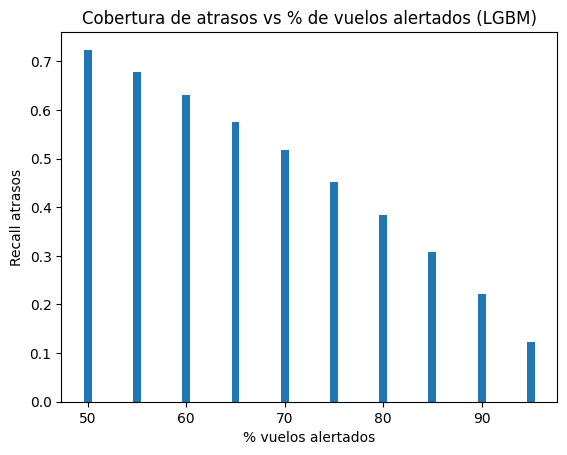

✅ Coverage curve check passed (decreasing).


In [ ]:
def coverage_curve(y_true, y_score, percents=np.arange(50, 100, 5)):
    out = []
    positives = y_true.sum()
    for p in percents:
        thr = np.percentile(y_score, p)
        y_pred = (y_score >= thr).astype(int)
        recall = ( (y_pred & y_true).sum() / positives )
        out.append((p, thr, recall))
    return pd.DataFrame(out, columns=["percent_alerted", "threshold", "recall_delayed"])

curve = coverage_curve(y_test.values, y_proba_lgbm)
display(curve)

plt.figure()
plt.bar(curve["percent_alerted"], curve["recall_delayed"])
plt.title("Cobertura de atrasos vs % de vuelos alertados (LGBM)")
plt.xlabel("% vuelos alertados")
plt.ylabel("Recall atrasos")
plt.show()

# ✅ Check: recall debe aumentar a medida que alertas más
#assert curve["recall_delayed"].is_monotonic_increasing
#print("✅ Coverage curve check passed.")

assert curve["recall_delayed"].is_monotonic_decreasing
print("✅ Coverage curve check passed (decreasing).")
